# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.



- [1. Introducción](#1-introducción)

- [2. Fundamentos teóricos de funciones hash](#2-fundamentos-hash)
    - [2.1 Funciones Hash](#21-funciones-hash)
    - [2.2 Esquema Merkle–Damgård](#22-esquema-merkle-damgård)
    - [2.3 Algoritmo MD5](#23-algoritmo-md5)
- [3. Rainbow Table](#3-rainbow-tables)
    - [3.1 Definición](#31-Defición)
    - [3.2 Función de reducción](#32-función-de-reducción)
    - [3.3 Trade-off tiempo/memoria](#34-trade-off)
    - [3.4 Falsos positivos y limitaciones](#35-falsos-positivos)

- [4. Simulación del ataque](#4-simulación)
    - [4.1 Simulación de víctima](#41-simulación-víctima)
    - [4.2 Ataque al hash objetivo](#42-ataque)

- [5. Análisis de resultados](#5-análisis-de-resultados)

- [6. Conclusiones y recomendaciones](#6-conclusiones)

- [7. Aportación personal](#7-aportación-personal)

- [8. Código](#8-funciones-reutilizables)

## 1.Introducción

Este trabajo presenta la **implementación y evaluación de un ataque con Rainbow Tables** sobre el algoritmo hash MD5, centrado en un conjunto limitado de contraseñas numéricas de 4 dígitos ("0000" a "9999").

El objetivo es reproducir todo el proceso de generación, búsqueda y validación, con la siguiente estructura:


1. **Construcción de la Rainbow Table**: creación de cadenas mediante la combinación de MD5 y una función de reducción dependiente de la ronda.
2. **Simulación de víctima**: selección de una contraseña y obtención de su hash objetivo.
3. **Ataque al hash objetivo**: búsqueda inversa en la tabla y comprobación del resultado.Análisis de resultados: estudio de colisiones, cobertura del espacio y tasa de éxito.
4. **Aportación personal**: propuesta de mejorar algoritmo y evitar las colisiones.



## 2.Fundamentos criptográficos

### 2.1 Funciones Hash

#### Definición

Una función hash transforma una entrada de longitud arbitraria en una salida de longitud fija. Su propósito es condensar información compleja en una representación más breve y manipulable, actuando como una "huella digital" del dato original.

Se define matemáticamente como:

$$
H : U \longrightarrow M \quad \text{con} \quad x \mapsto H(x)
$$

donde:
- $U$ es el conjunto de entradas posibles (por ejemplo, cadenas binarias de cualquier longitud),
- $M$ es un conjunto finito de cadenas de longitud fija.

En este trabajo se emplea la función MD5, cuya imagen está contenida en $M = {(0,1)}^{128}$, lo que equivale a $2^{128}$ posibles hashes.

####  Ejemplo de codificación

Para ilustrar cómo se genera un hash, consideramos la palabra "hola" y analizamos sus primeros pasos:

1. **Codificación ASCII**:
   - h → 104 → 01101000
   - o → 111 → 01101111
   - l → 108 → 01101100
   - a → 97 → 01100001

   La concatenación binaria de estos caracteres es:

   `01101000 01101111 01101100 01100001`

2. **Preprocesamiento**:
   Se añade relleno (padding) y se dividen los bits en bloques, como exige el algoritmo.

3. **Transformación interna**:
   Se aplican operaciones no lineales (sumas modulares, rotaciones, funciones booleanas...) que mezclan los bloques.

4. **Hash final**:
   Se obtiene un resumen de 128 bits. Por ejemplo:

   $$
   H(\text{"hola"}) = \text{bc4b2a76b9719d911017c592}
   $$

Aunque el valor del hash es internamente una cadena binaria de 128 bits, generalmente se representa en hexadecimal. Esto se debe a que cada carácter hexadecimal representa 4 bits, por lo tanto es mucho más corta y legible que escribir todos los bits directamente.

> **Nota** El proceso se explica con más detalle en la sección 2.2 (Merkle–Damgård y MD5).

#### Longitud del hash y teorema del cumpleaños

Aunque $M = \\{0,1\\}^{128}$ contiene $2^{128}$ posibles valores, esta cantidad no es suficiente para evitar colisiones en la práctica. El teorema del cumpleaños indica que la probabilidad de que dos entradas distintas generen el mismo hash (colisión) se vuelve significativa tras generar aproximadamente:

$$
\sqrt{2^{128}} = 2^{64}
$$

valores diferentes. Por ello, MD5 ya no se considera seguro frente a ataques de colisión y ha sido sustituido por funciones con salidas más largas, como SHA-256 o SHA-3.



#### Propiedades criptográficas 

Una función hash segura debe cumplir las siguientes propiedades:

- **Determinismo**:
  $$\forall x, y \in U,\ x = y \Rightarrow H(x) = H(y)$$

- **Eficiencia computacional**:
  $$\exists\ A \text{ en tiempo polinomial tal que } A(x) = H(x)$$

- **Efecto avalancha**  
Cuando dos entradas $ x $ y $ x'$ difieren mínimamente (por ejemplo, en un solo bit), el número de bits distintos en sus respectivos hashes $H(x)$ y $H(x')$ debe ser aproximadamente $frac{n}{2}$, donde $ n $ es la longitud total del hash en bits.

$$
\text{Hamming}(H(x), H(x')) \approx \frac{n}{2} \quad \text{cuando } x \approx x'
$$


- **Resistencia a la preimagen**:
  $$\forall h \in M,\ \text{es computacionalmente inviable encontrar } x \in U \text{ tal que } H(x) = h$$

- **Resistencia a la segunda preimagen**:
  $$\forall x \in U,\ \text{es difícil encontrar } x' \neq x \text{ con } H(x') = H(x)$$

- **Resistencia a colisiones**:
  $$\text{Es difícil encontrar } x \neq x' \in U \text{ tales que } H(x) = H(x')$$

> **Nota**: La colisiones se desarrollarán con más detalle en la sección 2.5.

#### Usos actuales

Las funciones hash son fundamentales en numerosos sistemas criptográficos modernos. Sus aplicaciones abarcan tanto la protección como la verificación de datos en múltiples contextos. Entre sus usos más comunes destacan:

- **Verificación de integridad**: se calcula el hash de un archivo o mensaje original y se compara con el recibido. Si los hashes coinciden, se garantiza que el contenido no ha sido alterado.
- **Almacenamiento de contraseñas**: no se guarda la contraseña real, sino su hash (a menudo acompañado de un valor aleatorio llamado *salt*), lo que impide su recuperación directa.
- **Firmas digitales**: en lugar de firmar todo el documento, se firma su hash. Esto reduce el tamaño de la firma y permite verificar que el contenido no ha sido modificado.


### 2.2 Esquema Merkle–Damgård

El esquema Merkle–Damgård es una estructura fundamental para **construir funciones hash partir de funciones de compresión**. Este método permite procesar mensajes de longitud arbitraria y generar su correspondinte hash de tamaño fijo.

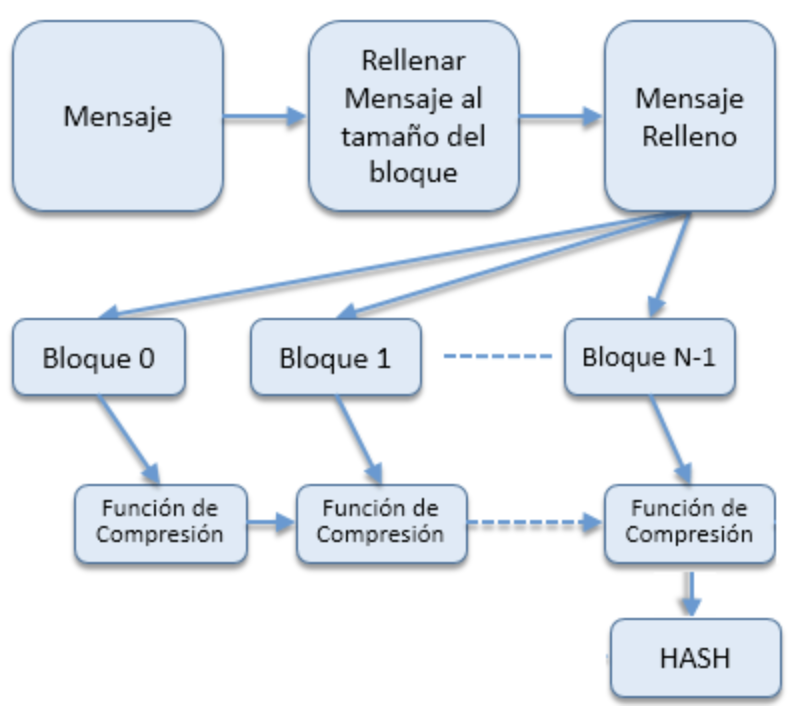

####  Mensaje original

El proceso comienza con un mensaje de entrada de cualquier longitud, que puede consistir en texto, datos binarios u otra tipo de información.

#### Padding

El mensaje original se somete a un proceso de "relleno" para adaptarlo al tamaño de bloque requerido por el algoritmo. Este paso garantiza que la longitud final sea múltiplo exacto del tamaño de bloque (ej. 512 bits para MD5). El padding incluye:

1. Añadir de un bit '1' al final del mensaje original (señalizar que a parti de este bit comienza el relleno)
2. Relleno con bits '0' hasta alcanzar la longitud requerida
3. Insertar al final los 64 bits que representan la longitud original del mensaje en binario

Este procedimiento elimina ambigüedades y asegura que mensajes diferentes produzcan cadenas de bits distintas.

El resultado del padding es un mensaje cuya **longitud es exactamente múltiplo del tamaño de bloque**, listo para ser dividido.

####  División en bloques
El mensaje rellenado se divide en N bloques de igual tamaño:

$$M = M₀ || M₁ || ... || M_{N-1}$$

Cada bloque Mᵢ será procesado secuencialmente por la función de compresión.


#### Función Compresión
Como se puede observar en el esquema se aplica iterativamente una función de compresión f.n. Esta combina cada bloque del mensaje con el resultado  anterior, generando un nuevo estado intermedio.:

1. Inicialización con un vector fijo $IV: H₀ = IV$
2. Para cada bloque $Mᵢ(i = 0,N-1)$:
   $$H_{i+1} = f(Hᵢ, Mᵢ)$$

Donde:
- $Hᵢ$ es el estado intermedio
- $Mᵢ$ es el bloque actual
- $f$ es la función de compresión específica del algoritmo

Finalmente,la salida de la última iteración  $(H_N)$ constituye el valor hash final. Este resumen tiene longitud fija (ej. 128 bits para MD5, 160 bits para SHA-1) y representa de forma única el mensaje original.

### 2.3 Algoritmo MD5


#### Definición
El algoritmo MD5 es una implementación concreta del esquema general **Merkle–Damgård**. Al igual que este, MD5 procesa el mensaje de entrada dividiéndolo en bloques de longitud fija y encadena los resultados parciales mediante una función de compresión.

La diferencia clave es que MD5 mantiene un estado interno compuesto por **cuatro registros de 32 bits cada uno: A, B, C y D**. Estos valores se inicializan con constantes predefinidas y se van transformando a lo largo del proceso. Al final, estos cuatro registros se combinan para formar el resumen (hash) final de 128 bits

####  1: Relleno del mensaje

El mensaje se **rellena siguiendo exactamente el mismo procedimiento descrito en el esquema Merkle–Damgård**: se añade un bit `1`, luego ceros `0`, y finalmente 64 bits con la longitud original del mensaje. El resultado se divide en bloques de 512 bits.

####  2: Inicialización

Se definen cuatro registros de 32 bits con valores fijos:

- A = `0x67452301`
- B = `0xefcdab89`
- C = `0x98badcfe`
- D = `0x10325476`

Estos registros forman el estado inicial del hash.

####  3: Procesamiento de bloques

Cada bloque de 512 bits se divide en **16 palabras de 32 bits**. Luego se aplican **64 operaciones**, organizadas en 64 rondas de 16 pasos, usando funciones lógicas específicas:


- **Ronda 1**: $ F(B,C,D) = (B \land C) \lor (\lnot B \land D) $
- **Ronda 2**:$ G(B,C,D) = (B \land D) \lor (C \land \lnot D) $
- **Ronda 3**: $ H(B,C,D) = B \oplus C \oplus D $
- **Ronda 4**: $ I(B,C,D) = C \oplus (B \lor \lnot D) $

En cada paso, se realiza lo siguiente:

1. Se aplica la función lógica correspondiente a la ronda.
2. Se suma una palabra $M_i $ del bloque y una **constante fija** $K_i$
3. El resultado se rota unos bits hacia la izquierda.
4. Se actualizan los valores de los registros A, B, C y D de forma cíclica.

Estas operaciones están diseñadas para asegurar  que incluso un pequeño cambio en el mensaje original altera completamente el resultado del hash.


#### 4: Encadenamiento

Al finalizar cada bloque, los registros A, B, C y D se **suman a sus valores anteriores**, y se usan como entrada para el siguiente bloque, manteniendo la estructura encadenada típica del esquema Merkle–Damgård.

#### 5: Resultado final

Tras procesar todos los bloques, los valores finales de A, B, C y D se concatenan para formar el hash MD5 de 128 bits, representado normalmente como una cadena hexadecimal de 32 caracteres.


##  3.Rainbow Table

### Definción

Una función hash, por definición, **no es invertible**,dado un valor hash $H(x)$, no es posible recuperar directamente la entrada x que lo generó. Esto se debe a que:
- La función no es inyectiva (por el principio del palomar).
- Muchas entradas distintas pueden producir el mismo valor hash (colisiones).
- La inversión computacional directa es inviable.

**Problema Planteado**

Sin embargo, en el problema que se nos plantea, las contraseñas válidas están restringidas al conjunto de cadenas numéricas de 4 cifras, es decir, desde `"0000"` hasta `"9999"`. Esto representa un espacio de búsqueda muy reducido: tan solo 10.000 posibles combinaciones.

Aunque las funciones hash están diseñadas para ser difíciles de invertir, en este caso particular sí resulta factible intentar hallar entradas que produzcan un determinado hash, ya que el número total de contraseñas posibles es bajo.

Para este escenario existen dos enfoques principales de ataque:

1. **Fuerza bruta**: consiste en probar sistemáticamente cada contraseña posible hasta encontrar aquella que, al aplicarle la función hash, produzca el valor deseado.
2. **Rainbow Tables**: se basa en precalcular una estructura de datos optimizada, donde se generan cadenas de transformación entre contraseñas y se almacena solo información parcial. Esto permite acelerar el proceso de búsqueda posterior, consumiendo mucha menos memoria que una tabla completa.

*El segundo enfoque es el que desarrollaremos en este trabajo.*

**Ejemplo**